In [1]:
import os
import cv2
import json
import re
from collections import defaultdict


root_path = '/export/home/datasets/beijingStation/20190720/'
label_name = 'check_20190720.txt'

label_path = os.path.join(root_path, label_name)

with open(label_path, 'r') as f:
    bboxes = [i.strip() for i in f.readlines()]


camBox = defaultdict(list)
camPid = defaultdict(set)
pidCam = defaultdict(set)
pidBox = defaultdict(list)
for i, b in enumerate(bboxes):
    pid, cam_img, xmin, ymin, xmax, ymax = b.split(' ')
    video_name, img_name = cam_img.split('_')
    camBox[video_name].append(img_name)
    camPid[video_name].add(pid)
    pidCam[pid].add(video_name)
    pidBox[pid].append(img_name)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
import numpy as np

In [36]:
len(set(camPid['vedio10']))

4099

In [42]:
camName = list(camBox.keys())
imgNum = list()
imgPid = list()
for n in camName:
    imgNum.append(len(camBox[n]))
    imgPid.append(len(camPid[n]))

In [62]:
camPidNum = dict([(i, 0) for i in range(1, len(camName)+1)])
for i,k in pidCam.items():
    camPidNum[len(k)] += 1

In [63]:
camPidNum

{1: 9328, 2: 1241, 3: 117, 4: 0, 5: 0, 6: 0}

Text(0.5, 1.0, 'Number of images in different cameras')

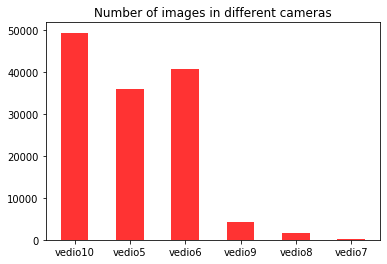

In [50]:
plt.bar(camName, height=imgNum, width=0.5, alpha=0.8, color='red')
plt.title("Number of images in different cameras")

In [89]:
imgNum

[49455, 36068, 40793, 4363, 1602, 201]

Text(0.5, 1.0, 'Number of persons in different cameras')

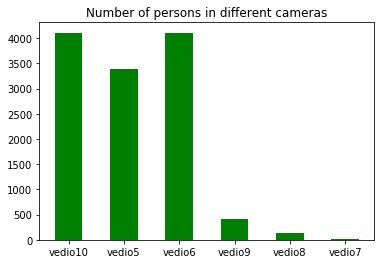

In [51]:
plt.bar(camName, height=imgPid, width=0.5, color='green')
plt.title("Number of persons in different cameras")

In [90]:
imgPid

[4099, 3394, 4108, 407, 137, 16]

Text(0.5, 1.0, 'Number of persons appearance in different cameras')

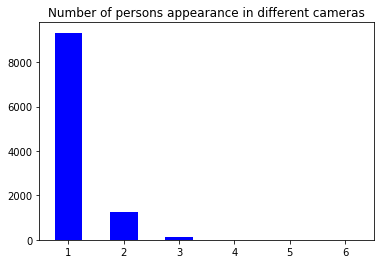

In [65]:
plt.bar(camPidNum.keys(), height=camPidNum.values(), width=0.5, color='blue')
plt.title("Number of persons appearance in different cameras")

In [91]:
camPidNum

{1: 9328, 2: 1241, 3: 117, 4: 0, 5: 0, 6: 0}

In [67]:
pidName = list()
pidNumber = list()
for i,k in pidBox.items():
    pidName.append(i)
    pidNumber.append(len(k))

<BarContainer object of 10686 artists>

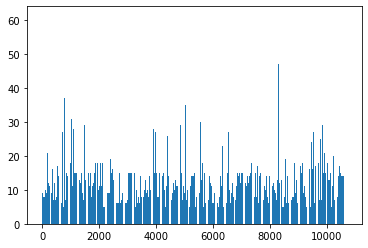

In [88]:
plt.bar(np.arange(len(pidName)), height=pidNumber)
plt.title("number of images for different id")

In [1]:
from fastai.vision import *

In [2]:
def get_ex(): return open_image('datasets/beijingStation/query/000245_c10s2_1561732033722.000000.jpg')

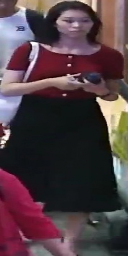

In [161]:
get_ex().apply_tfms(crop_pad(), size=(256,128))

In [1]:
from fastai.vision import *

In [2]:
state_dict = torch.load('logs/beijing/test/models/model_0.pth')

In [3]:
from modeling import Baseline

In [4]:
model = Baseline(2344, 1, None)
model.load_state_dict(state_dict['model'])

model.eval()
model = model.cuda(0)

In [4]:
from data.build import get_data_bunch

In [93]:
from config import cfg

In [94]:
data_bunch, test_labels, num_query = get_data_bunch(cfg)

Note: if root path is changed, the previously generated json files need to be re-generated (delete them first)
Split index = 0


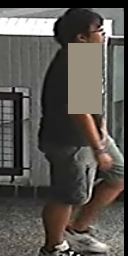

In [120]:
data_bunch.train_ds[0][0]

In [96]:
from data.datasets.eval_reid import evaluate

/export/home/lxy/reid_baseline/data/datasets/eval_reid.py:18: UserWarning: Cython evaluation is UNAVAILABLE, which is highly recommended
  warnings.warn("Cython evaluation is UNAVAILABLE, which is highly recommended")


In [9]:
import numpy as np

In [10]:
pids = []
camids = []
for i in test_labels:
    pids.append(i[0])
    camids.append(i[1])
q_pids = np.asarray(pids[:num_query])
q_camids = np.asarray(camids[:num_query])
g_pids = np.asarray(pids[num_query:])
g_camids = np.asarray(camids[num_query:])

feats, pids, camids = [], [], []
for imgs, _ in data_bunch.test_dl:
    with torch.no_grad():
        feat = model(imgs)
        feats.append(feat)
feats = torch.cat(feats, dim=0)
feats = F.normalize(feats, p=2, dim=1)

qf = feats[:num_query]
gf = feats[num_query:]

m, n = qf.shape[0], gf.shape[0]
distmat = torch.pow(qf, 2).sum(dim=1, keepdim=True).expand(m, n) + torch.pow(gf, 2).sum(dim=1, keepdim=True).expand(n, m).t()
distmat.addmm_(1, -2, qf, gf.t())
distmat = to_np(distmat)
cmc, mAP = evaluate(distmat, q_pids, g_pids, q_camids, g_camids)

In [4]:
from fastai.vision import *

In [5]:
from data import get_data_bunch
from modeling import build_model

In [6]:
from config import cfg

In [7]:
model = build_model(cfg, 751)

Not load imagenet pretrained model!


In [8]:
cfg.DATASETS.NAMES = ('market1501',)

In [9]:
data, _, _ = get_data_bunch(cfg)

In [10]:
from layers import make_loss

In [11]:
learn = Learner(data=data, model=model, loss_func=make_loss(cfg), path='logs', )

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from fastai.basic_train import Learner

from engine.interpreter import ReidInterpretation

from data import get_data_bunch

from config import cfg
cfg.DATASETS.TEST_NAMES = 'bj'
cfg.MODEL.BACKBONE = 'resnet50_ibn'

data_bunch, test_labels, num_query = get_data_bunch(cfg)

from modeling import Baseline

model = Baseline(cfg.MODEL.BACKBONE, 10, 1)
model.load_params_wo_fc(torch.load('logs/2019.8.12/bj/ibn_lighting/models/model_119.pth')['model'])
learn = Learner(data_bunch, model)

Note: if root path is changed, the previously generated json files need to be re-generated (delete them first)
Split index = 0
not load imagenet pretrained model!


In [3]:
reidInterpreter = ReidInterpretation(learn, test_labels, num_query)

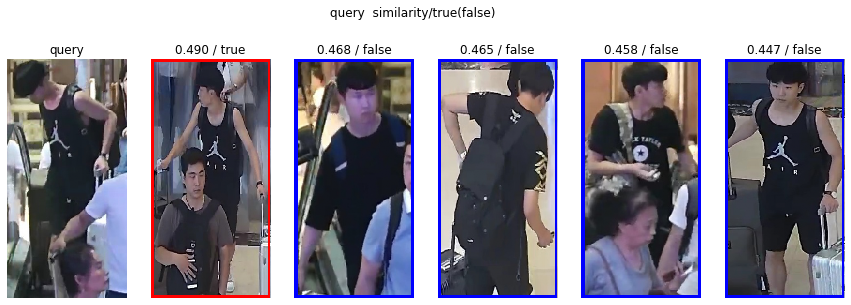

In [5]:
a = reidInterpreter.plot_rank_result(1,5)

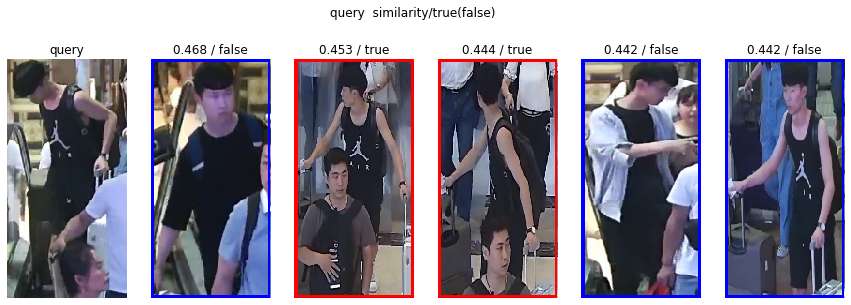

In [17]:
a = reidInterpreter.plot_rank_result(1,5)

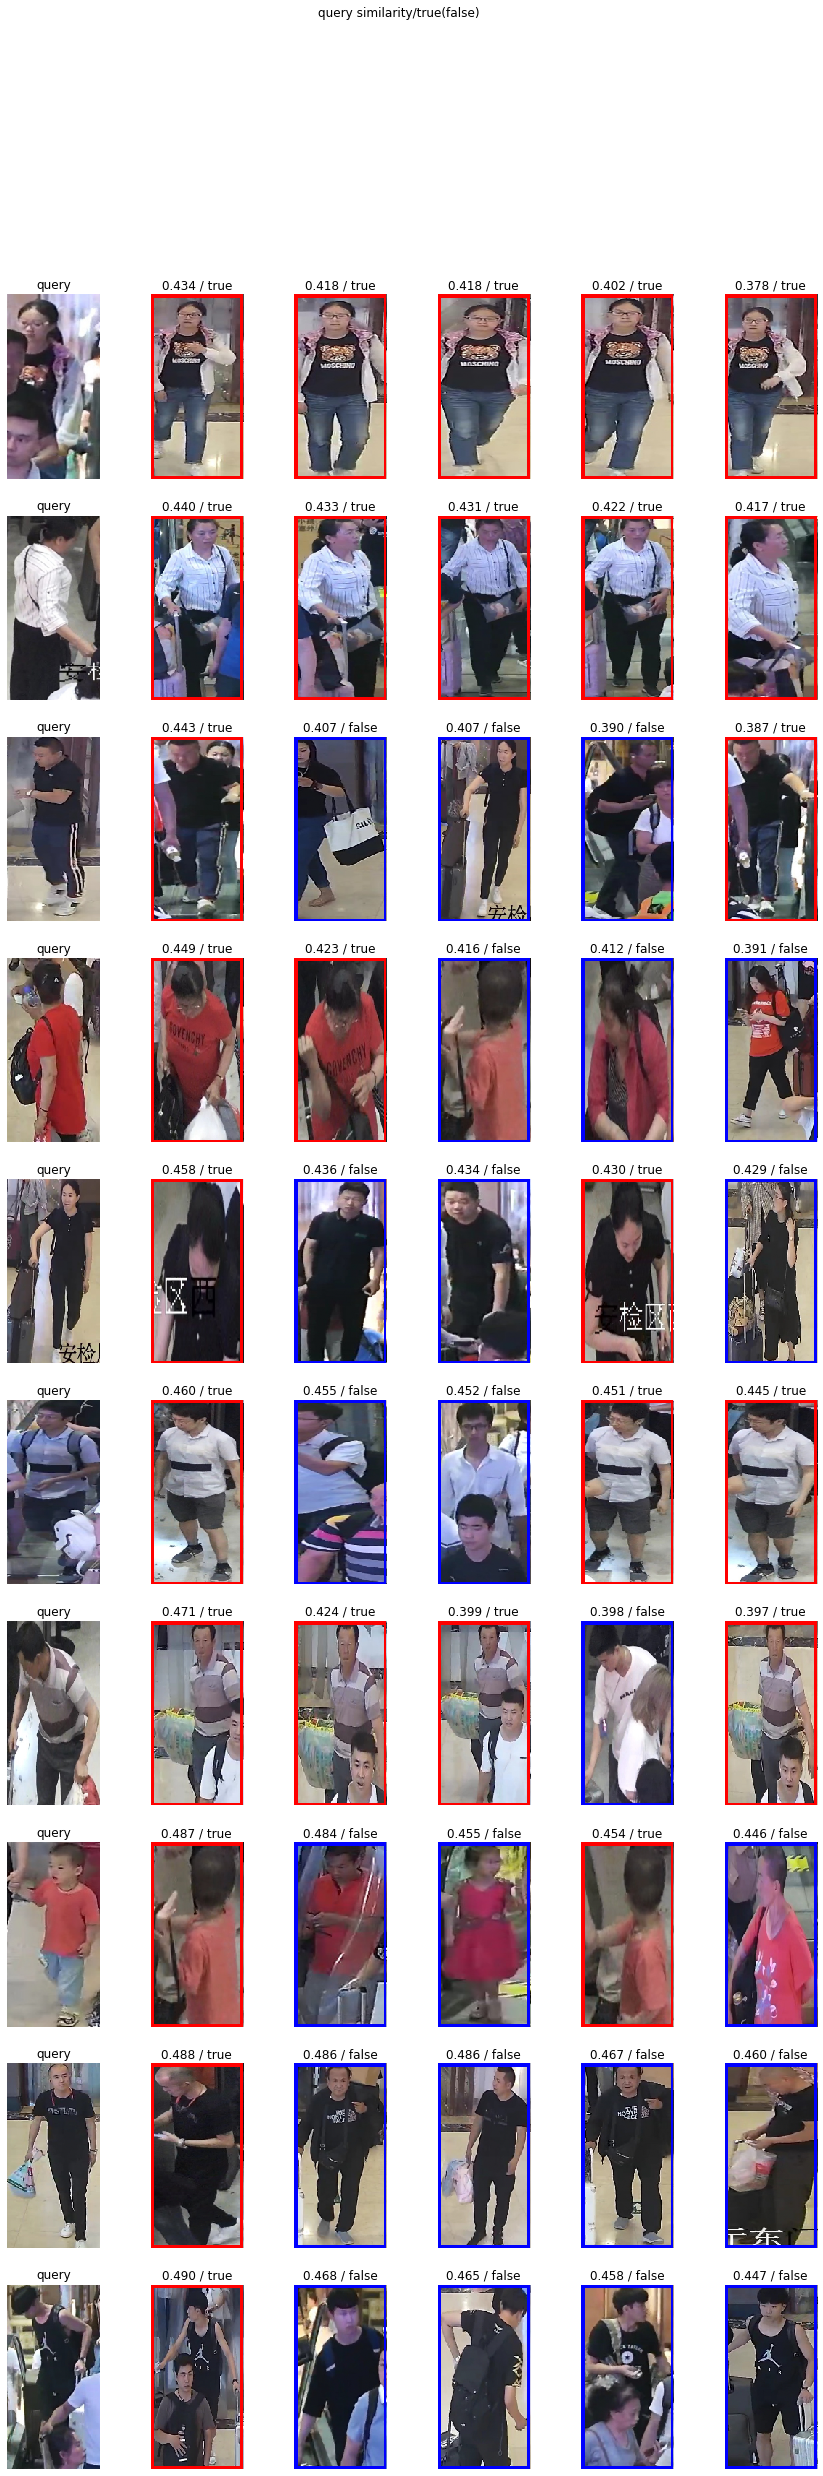

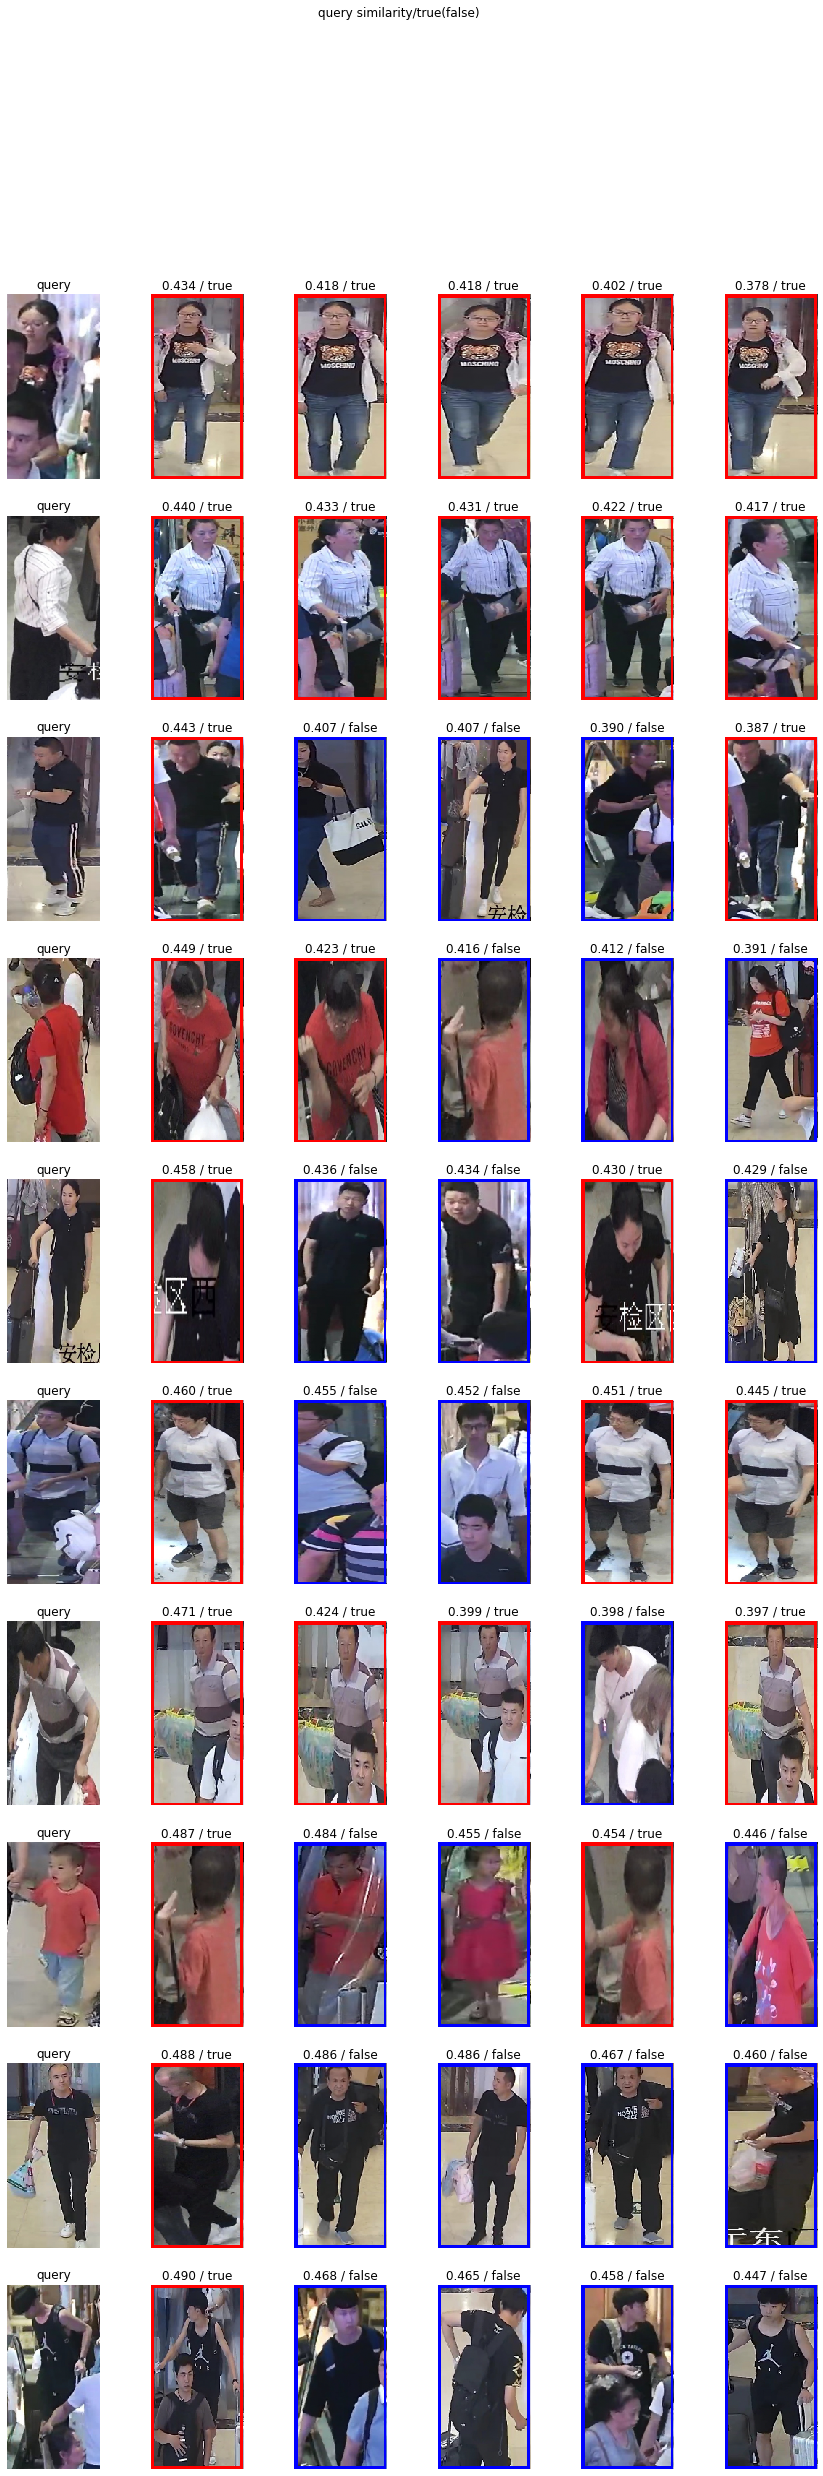

In [35]:
reidInterpreter.plot_top_error(10, True)

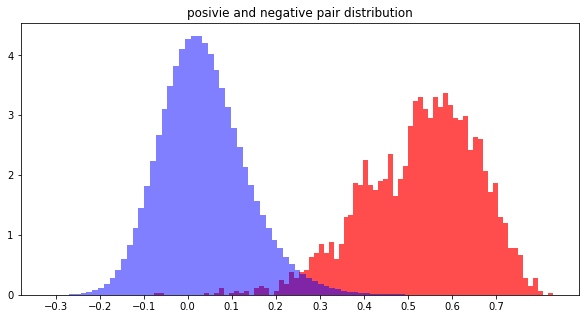

In [39]:
pos_sim,neg_sim=reidInterpreter.plot_positve_negative_dist()

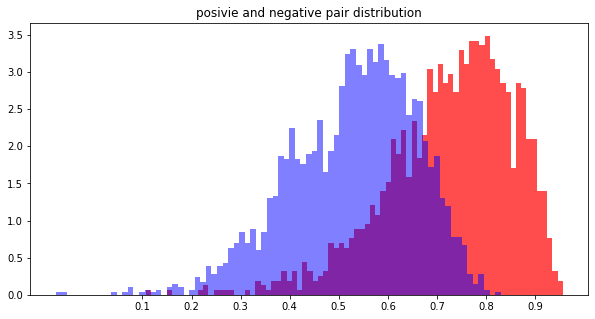

<Figure size 720x360 with 1 Axes>


In [52]:
reidInterpreter.plot_same_cam_diff_cam_dist()